# AP location prediction 
**Following the methods explored in the `ap_coordinates_prediction_review.ipynb`**

In [1]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

## Load data 

In [2]:
path = '../data/ap_data_all_floors.csv'  
data = pd.read_csv(path)
print(data.shape)

(70452, 70)


In [3]:
# Set max valid RSSI to 200
data = data.dropna(subset=[data.columns[-1]])
data.replace({np.nan: 200}, inplace=True)
data.iloc[:, 4:-4] = data.iloc[:, 4:-4].clip(upper=200)

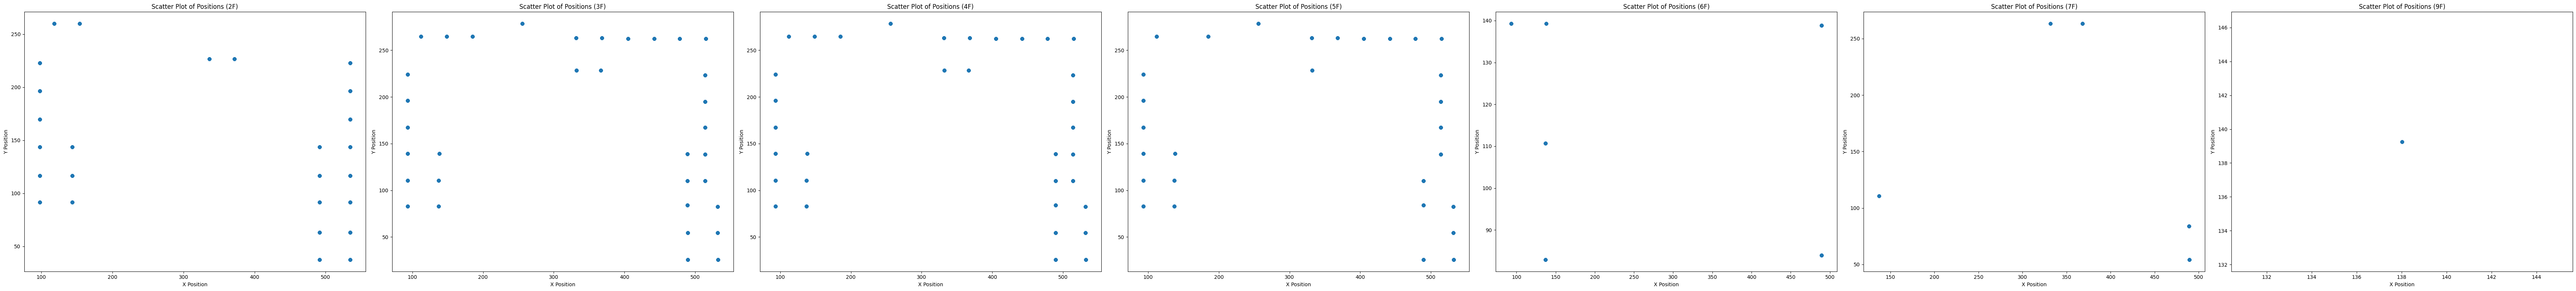

In [4]:
unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
num_floors = len(unique_floors)
fig, axes = plt.subplots(1, num_floors, figsize=(20 * num_floors // 2, 8))

for i, floor in enumerate(sorted(unique_floors)):
    floor_data = data[data['ap_name'].str.contains(floor)]
    axes[i].scatter(floor_data.iloc[:, -3], floor_data.iloc[:, -2])
    axes[i].set_xlabel('X Position')
    axes[i].set_ylabel('Y Position')
    axes[i].set_title(f'Scatter Plot of Positions ({floor})')

plt.tight_layout()
plt.show()

There isn't enough data to cover all the access points (APs), so some floors appear empty due to the lack of data for all APs on those floors

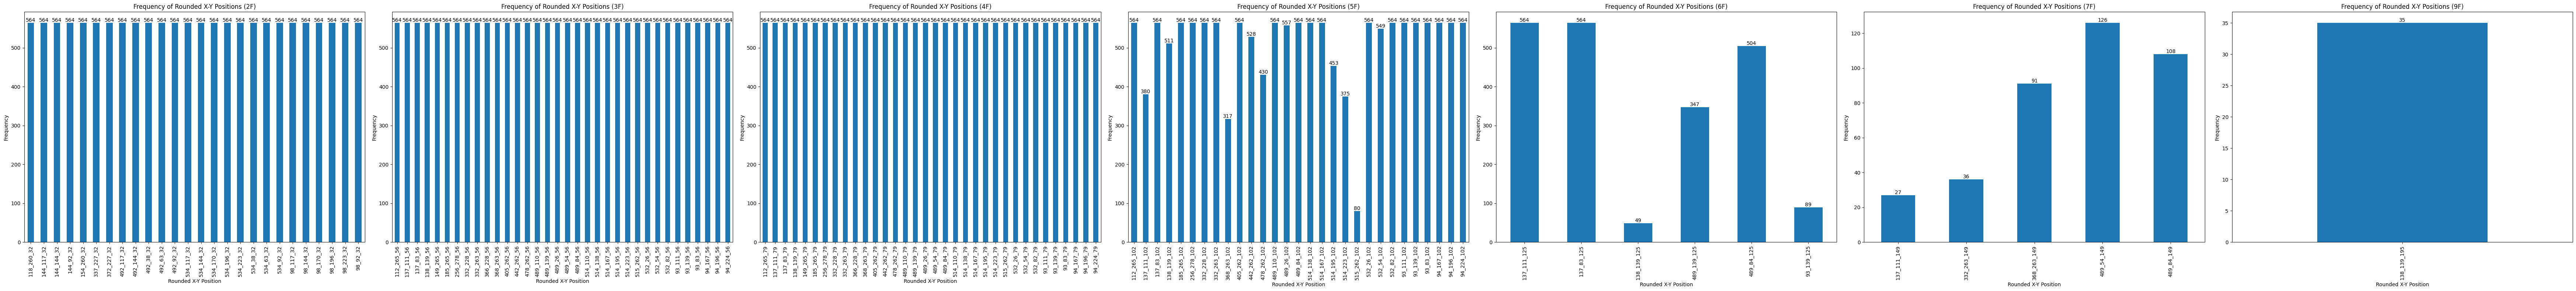

In [5]:
data['rounded_position'] = data.apply(lambda row: f"{int(round(row.iloc[-3]))}_{int(round(row.iloc[-2]))}_{int(round(row.iloc[-1]))}", axis=1)

unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
num_floors = len(unique_floors)
fig, axes = plt.subplots(1, num_floors, figsize=(20 * num_floors // 2, 8))

for i, floor in enumerate(sorted(unique_floors)):
    floor_data = data[data['ap_name'].str.contains(floor)]
    position_counts = floor_data['rounded_position'].value_counts().sort_index()
    
    position_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Frequency of Rounded X-Y Positions ({floor})')
    axes[i].set_xlabel('Rounded X-Y Position')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90)
    
    for j, v in enumerate(position_counts):
        axes[i].text(j, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Data Distribution

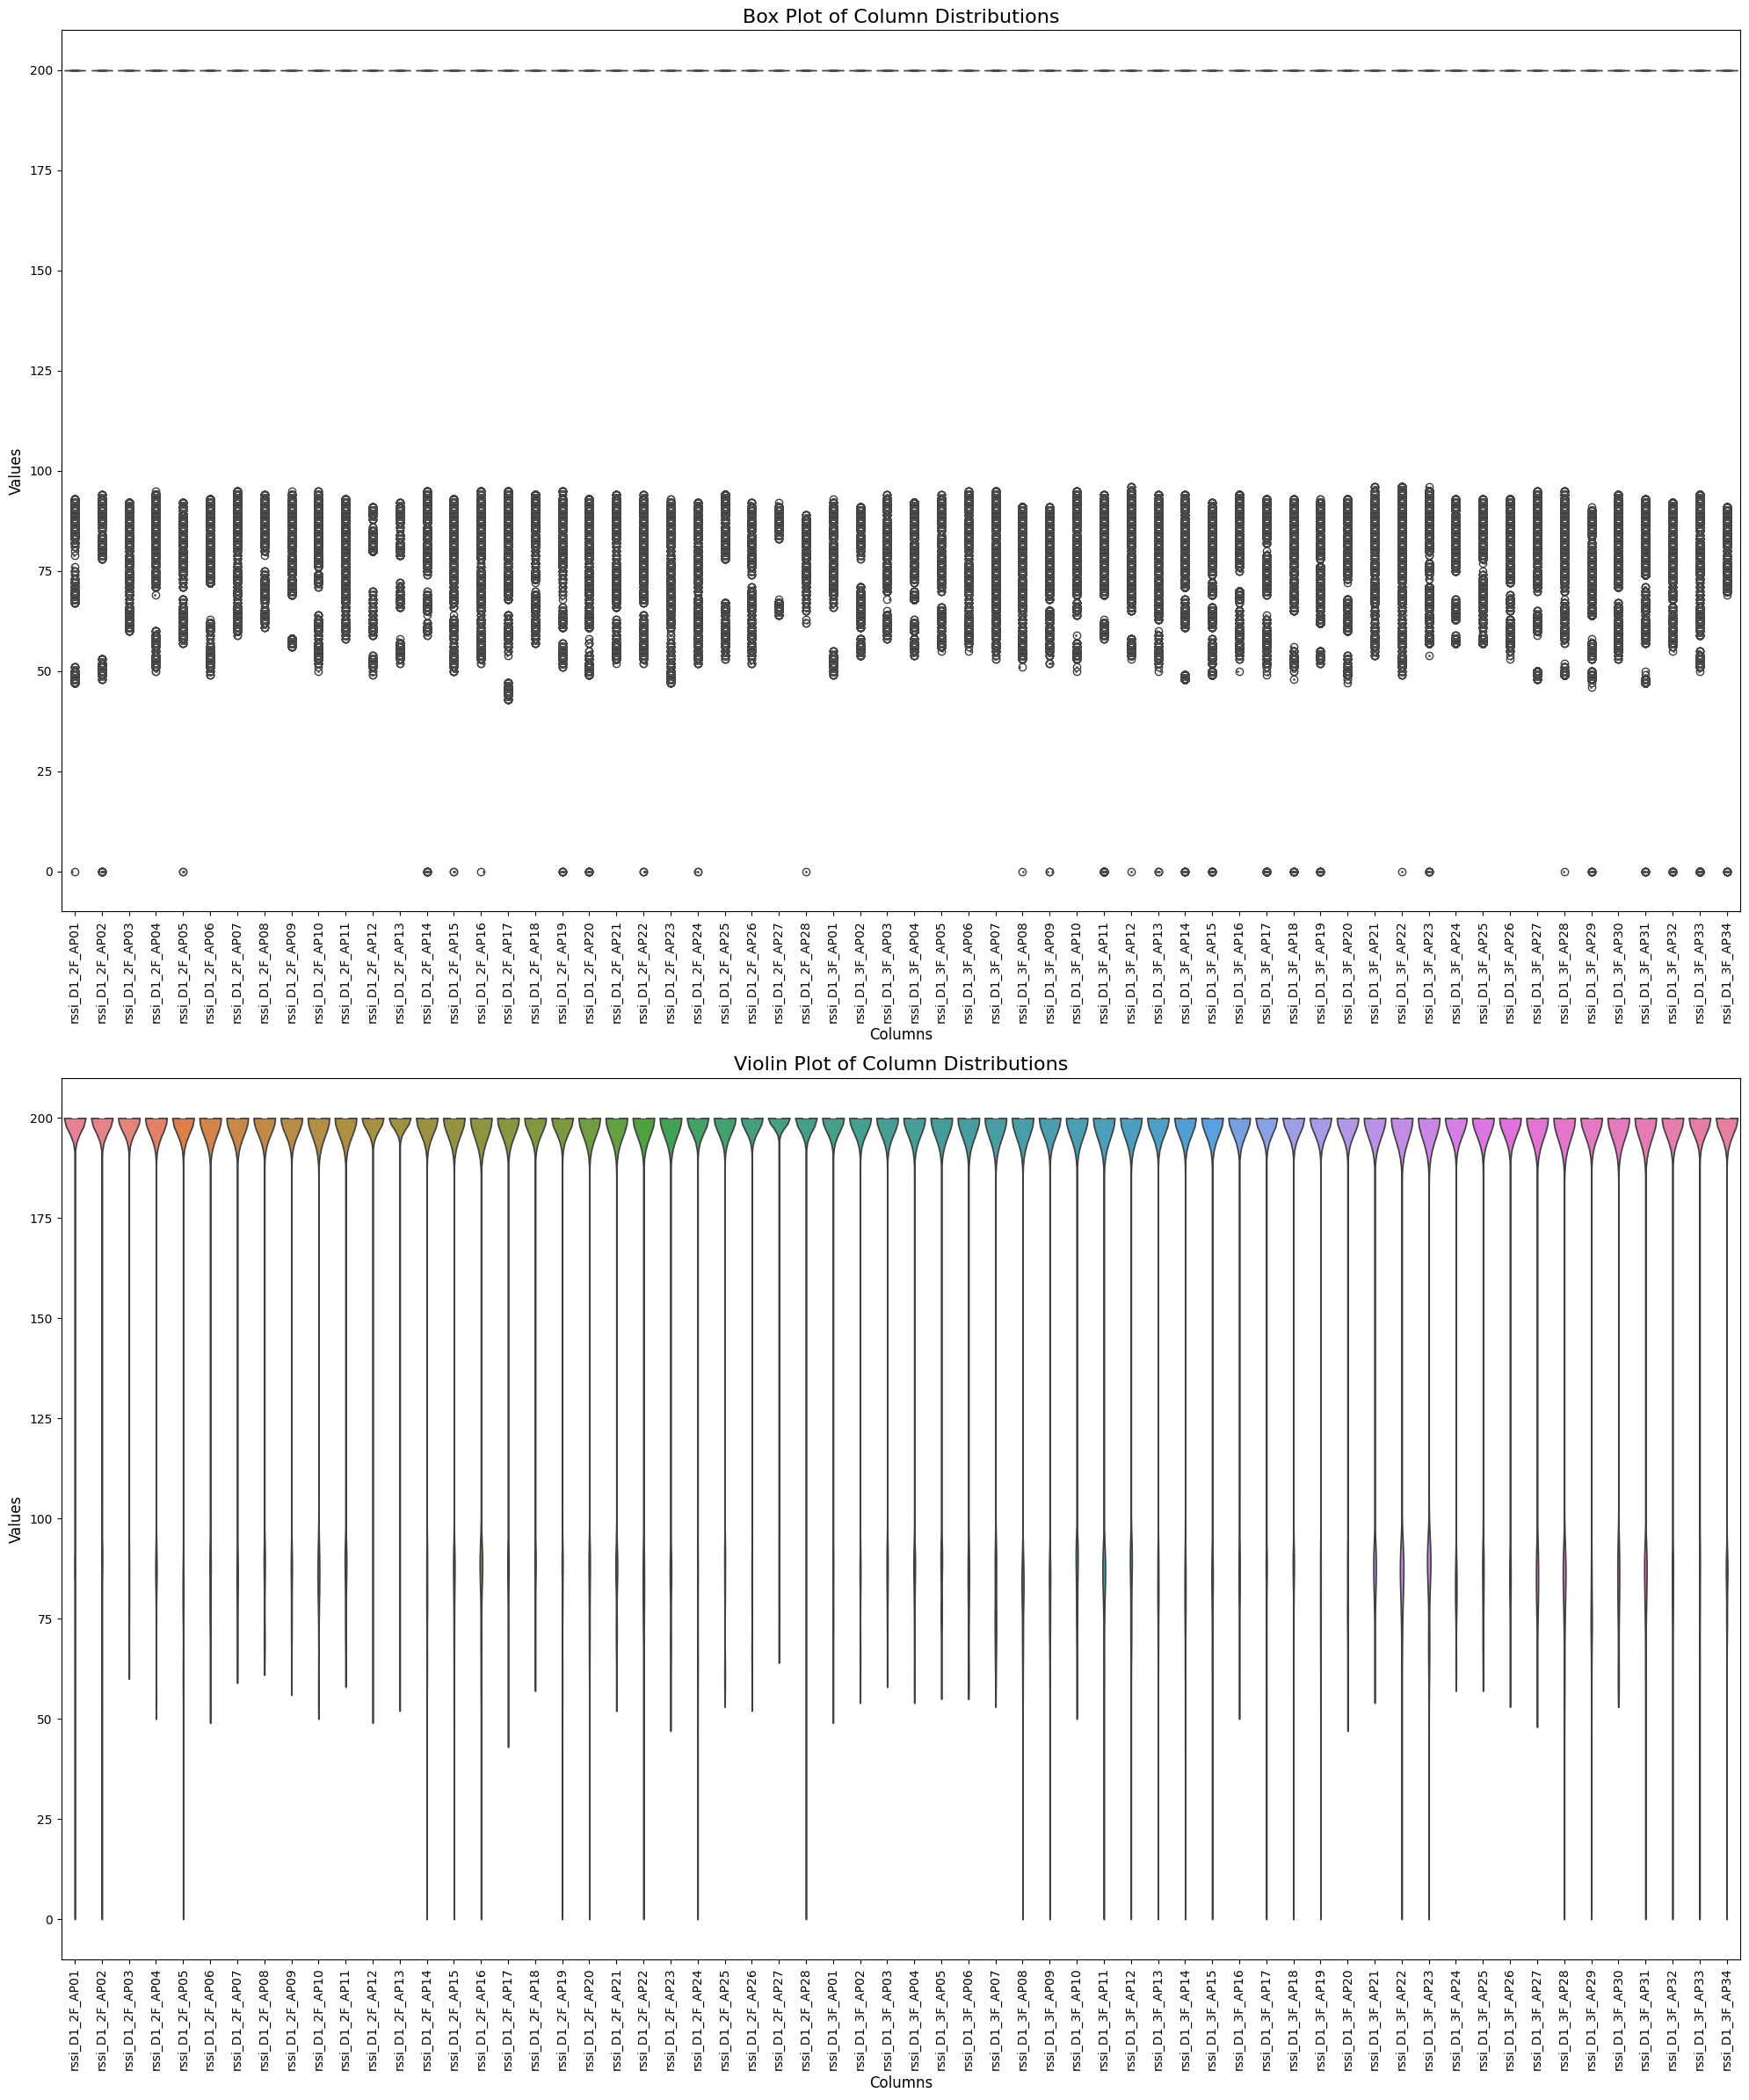

       rssi_D1_2F_AP01  rssi_D1_2F_AP02  rssi_D1_2F_AP03  rssi_D1_2F_AP04  \
count     70452.000000     70452.000000     70452.000000     70452.000000   
mean        192.360288       191.579529       191.822461       188.136064   
std          29.432093        30.365835        30.633302        35.887814   
min           0.000000         0.000000        60.000000        50.000000   
25%         200.000000       200.000000       200.000000       200.000000   
50%         200.000000       200.000000       200.000000       200.000000   
75%         200.000000       200.000000       200.000000       200.000000   
max         200.000000       200.000000       200.000000       200.000000   

       rssi_D1_2F_AP05  rssi_D1_2F_AP06  rssi_D1_2F_AP07  rssi_D1_2F_AP08  \
count     70452.000000     70452.000000     70452.000000     70452.000000   
mean        189.676986       184.793221       185.674473       187.391117   
std          34.398806        40.528818        39.269083        36.751718  

In [6]:
# Select the columns we want to plot
selected_data = data.iloc[:, 4:-4]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 24))

# Box plot
sns.boxplot(data=selected_data, ax=ax1, whis=1.5)
ax1.set_title('Box Plot of Column Distributions', fontsize=16)
ax1.set_xlabel('Columns', fontsize=12)
ax1.set_ylabel('Values', fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# Add strip plot to show individual points
sns.stripplot(data=selected_data, ax=ax1, size=2, color=".3", linewidth=0)

# Violin plot
sns.violinplot(data=selected_data, ax=ax2, cut=0)
ax2.set_title('Violin Plot of Column Distributions', fontsize=16)
ax2.set_xlabel('Columns', fontsize=12)
ax2.set_ylabel('Values', fontsize=12)
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()

plt.show()

print(selected_data.describe())

## Label Encoding

In [7]:
def encode_and_save_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Fit and transform the data
    encoded_values = le.fit_transform(data[column_name])
    
    # Replace the original column with encoded values
    data[column_name] = encoded_values
    
    # Save the encoder to a file
    with open(encoder_file_name, 'wb') as file:
        pickle.dump(le, file)
    
    print(f"Encoded {column_name} and saved encoder to {encoder_file_name}")
    
    return data

def decode_labels(data, column_name, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded values back to original labels
    decoded_values = le.inverse_transform(data[column_name])
    
    # Replace the encoded column with decoded values
    data[column_name] = decoded_values
    
    print(f"Decoded {column_name} using encoder from {encoder_file_name}")
    
    return data

def decode_predictions(y_pred, encoder_file_name='label_encoder.pkl'):
    # Load the encoder from the file
    with open(encoder_file_name, 'rb') as file:
        le = pickle.load(file)
    
    # Transform the encoded predictions back to original labels
    decoded_predictions = le.inverse_transform(y_pred)
    
    print(f"Decoded predictions using encoder from {encoder_file_name}")
    
    return decoded_predictions

## To see the mapping
#with open('label_encoder.pkl', 'rb') as file:
#    le = pickle.load(file)
#    print("Label Mapping:")
#    for i, label in enumerate(le.classes_):
#        print(f"{label} -> {i}")

In [8]:
df = data.iloc[:, 4:-4]
df = encode_and_save_labels(df, 'ap_name')
df = df.rename(columns={'ap_name': 'label'})

Encoded ap_name and saved encoder to label_encoder.pkl


In [9]:
df

,rssi_D1_2F_AP01,rssi_D1_2F_AP02,rssi_D1_2F_AP03,rssi_D1_2F_AP04,rssi_D1_2F_AP05,rssi_D1_2F_AP06,rssi_D1_2F_AP07,rssi_D1_2F_AP08,rssi_D1_2F_AP09,rssi_D1_2F_AP10,...,rssi_D1_3F_AP26,rssi_D1_3F_AP27,rssi_D1_3F_AP28,rssi_D1_3F_AP29,rssi_D1_3F_AP30,rssi_D1_3F_AP31,rssi_D1_3F_AP32,rssi_D1_3F_AP33,rssi_D1_3F_AP34,label
0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,89.0,85.0,...,200.0,200.0,87.0,200.0,200.0,200.0,200.0,200.0,200.0,15
1,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,112
2,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,89.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,116
3,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,75.0,63.0,200.0,25
4,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,79.0,74.0,50.0,200.0,55.0,75.0,80.0,200.0,200.0,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70447,92.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,61
70448,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,74.0,93
70449,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,85.0,79.0,84.0,200.0,200.0,200.0,200.0,200.0,200.0,49
70450,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,111


## Scaling using Robust Scaler

In [10]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]  

In [11]:
robust_scaled_data = RobustScaler().fit_transform(X)

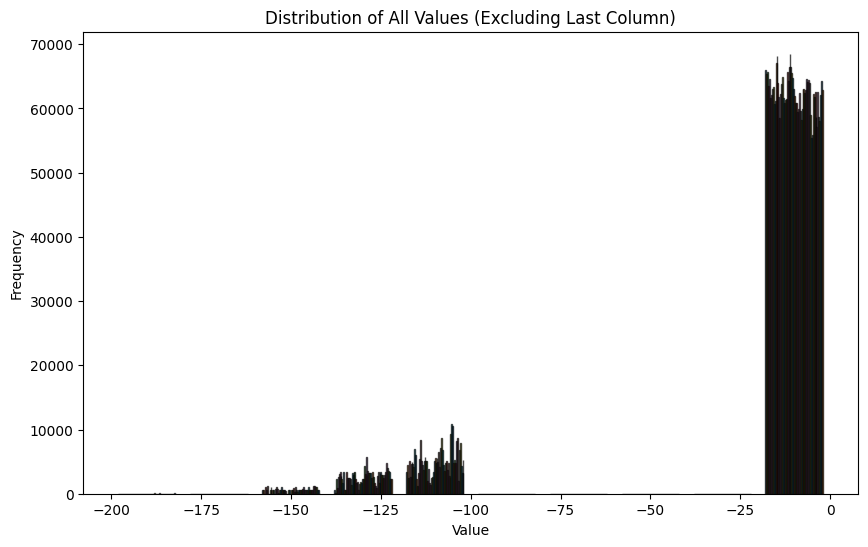

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(robust_scaled_data, edgecolor='k', alpha=0.7)
plt.title('Distribution of All Values (Excluding Last Column)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### Are there overlapping points in the data?

In [13]:
binned_data = df.copy()
binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
overlapping_points = overlapping_points[overlapping_points > 1]
overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

overlapping_data

label
rssi_D1_2F_AP01 rssi_D1_2F_AP02 rssi_D1_2F_AP03 rssi_D1_2F_AP04 rssi_D1_2F_AP05 rssi_D1_2F_AP06 rssi_D1_2F_AP07 rssi_D1_2F_AP08 rssi_D1_2F_AP09 rssi_D1_2F_AP10 rssi_D1_2F_AP11 rssi_D1_2F_AP12 rssi_D1_2F_AP13 rssi_D1_2F_AP14 rssi_D1_2F_AP15 rssi_D1_2F_AP16 rssi_D1_2F_AP17 rssi_D1_2F_AP18 rssi_D1_2F_AP19 rssi_D1_2F_AP20 rssi_D1_2F_AP21 rssi_D1_2F_AP22 rssi_D1_2F_AP23 rssi_D1_2F_AP24 rssi_D1_2F_AP25 rssi_D1_2F_AP26 rssi_D1_2F_AP27 rssi_D1_2F_AP28 rssi_D1_3F_AP01 rssi_D1_3F_AP02 rssi_D1_3F_AP03 rssi_D1_3F_AP04 rssi_D1_3F_AP05 rssi_D1_3F_AP06 rssi_D1_3F_AP07 rssi_D1_3F_AP08 rssi_D1_3F_AP09 rssi_D1_3F_AP10 rssi_D1_3F_AP11 rssi_D1_3F_AP12 rssi_D1_3F_AP13 rssi_D1_3F_AP14 rssi_D1_3F_AP15 rssi_D1_3F_AP16 rssi_D1_3F_AP17 rssi_D1_3F_AP18 rssi_D1_3F_AP19 rssi_D1_3F_AP20 rssi_D1_3F_AP21 rssi_D1_3F_AP22 rssi_D1_3F_AP23 rssi_D1_3F_AP24 rssi_D1_3F_AP25 rssi_D1_3F_AP26 rssi_D1_3F_AP27 rssi_D1_3F_AP28 rssi_D1_3F_AP29 rssi_D1_3F_AP30 rssi_D1_3F_AP31 rssi_D1_3F_AP32 rssi_D1_3F_AP33 rssi_D1_3F_AP34       
200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           93.0            200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0           200.0              128
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                200.0              128
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                200.0              12

In [14]:
# delete overlapping data 
non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
df = df[non_overlapping_mask]
df.shape

(68466, 63)

## Model XGBClassifier With Standard Scaler

In [15]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

dataset = CustomDataset(robust_scaled_data, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [17]:
y_train.size, y_val.size, y_test.size

(49597, 6764, 14091)

In [18]:
# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False)

# Train the model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [19]:
# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00       126
           2       1.00      1.00      1.00       115
           3       1.00      1.00      1.00       110
           4       1.00      1.00      1.00       108
           5       1.00      1.00      1.00       115
           6       1.00      1.00      1.00       135
           7       1.00      1.00      1.00        97
           8       1.00      1.00      1.00       117
           9       1.00      1.00      1.00       101
          10       1.00      1.00      1.00       102
          11       1.00      1.00      1.00       112
          12       1.00      1.00      1.00        97
          13       1.00      0.99      1.00       124
          14       1.00      1.00      1.00       113
          15       1.00      1.00      1.00        94
          16       1.00      1.00      1.00

/home/sai/miniconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sai/miniconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sai/miniconda3/envs/pai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [20]:
decoded_y_pred = decode_predictions(y_pred)
decoded_y_test = decode_predictions(y_test)

Decoded predictions using encoder from label_encoder.pkl
Decoded predictions using encoder from label_encoder.pkl


In [21]:
def plot_ap_positions(data, y_test, y_pred):
    unique_floors = data['ap_name'].str.extract('(\d+F)')[0].unique()
    num_floors = len(unique_floors)
    fig, axes = plt.subplots(1, num_floors, figsize=(12 * num_floors // 2, 8))

    ap_positions = dict(zip(data['ap_name'], zip(data['x'], data['y'])))

    for i, floor in enumerate(sorted(unique_floors)):
        floor_mask = [floor in ap for ap in y_test]
        floor_y_test = y_test[floor_mask]
        floor_y_pred = y_pred[floor_mask]

        test_positions = [ap_positions[ap] for ap in floor_y_test]
        pred_positions = [ap_positions[ap] for ap in floor_y_pred]

        position_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})
        for true_pos, true_ap, pred_ap in zip(test_positions, floor_y_test, floor_y_pred):
            position_accuracy[true_pos]['total'] += 1
            if true_ap == pred_ap:
                position_accuracy[true_pos]['correct'] += 1

        position_percentage = {pos: (data['correct'] / data['total']) * 100 
                               for pos, data in position_accuracy.items()}

        x_test, y_test_coords = zip(*test_positions)
        x_pred, y_pred_coords = zip(*pred_positions)

        axes[i].scatter(x_test, y_test_coords, c='green', marker='o', s=200, alpha=0.5, label='Ground Truth')
        scatter = axes[i].scatter(x_pred, y_pred_coords, 
                                  c=[position_percentage.get(pos, 0) for pos in test_positions],
                                  cmap='RdYlGn', vmin=0, vmax=100, s=50, alpha=0.7)

        correct_predictions = sum(true == pred for true, pred in zip(floor_y_test, floor_y_pred))
        total_predictions = len(floor_y_test)
        overall_accuracy = (correct_predictions / total_predictions) * 100

        axes[i].set_title(f'AP Positions on {floor}\nAccuracy: {overall_accuracy:.2f}%')
        axes[i].set_xlabel('X Position')
        axes[i].set_ylabel('Y Position')
        axes[i].grid(True)

    plt.tight_layout()
    cbar = fig.colorbar(scatter, ax=axes.ravel().tolist())
    cbar.set_label('Percentage of Correct Predictions')
    plt.show()

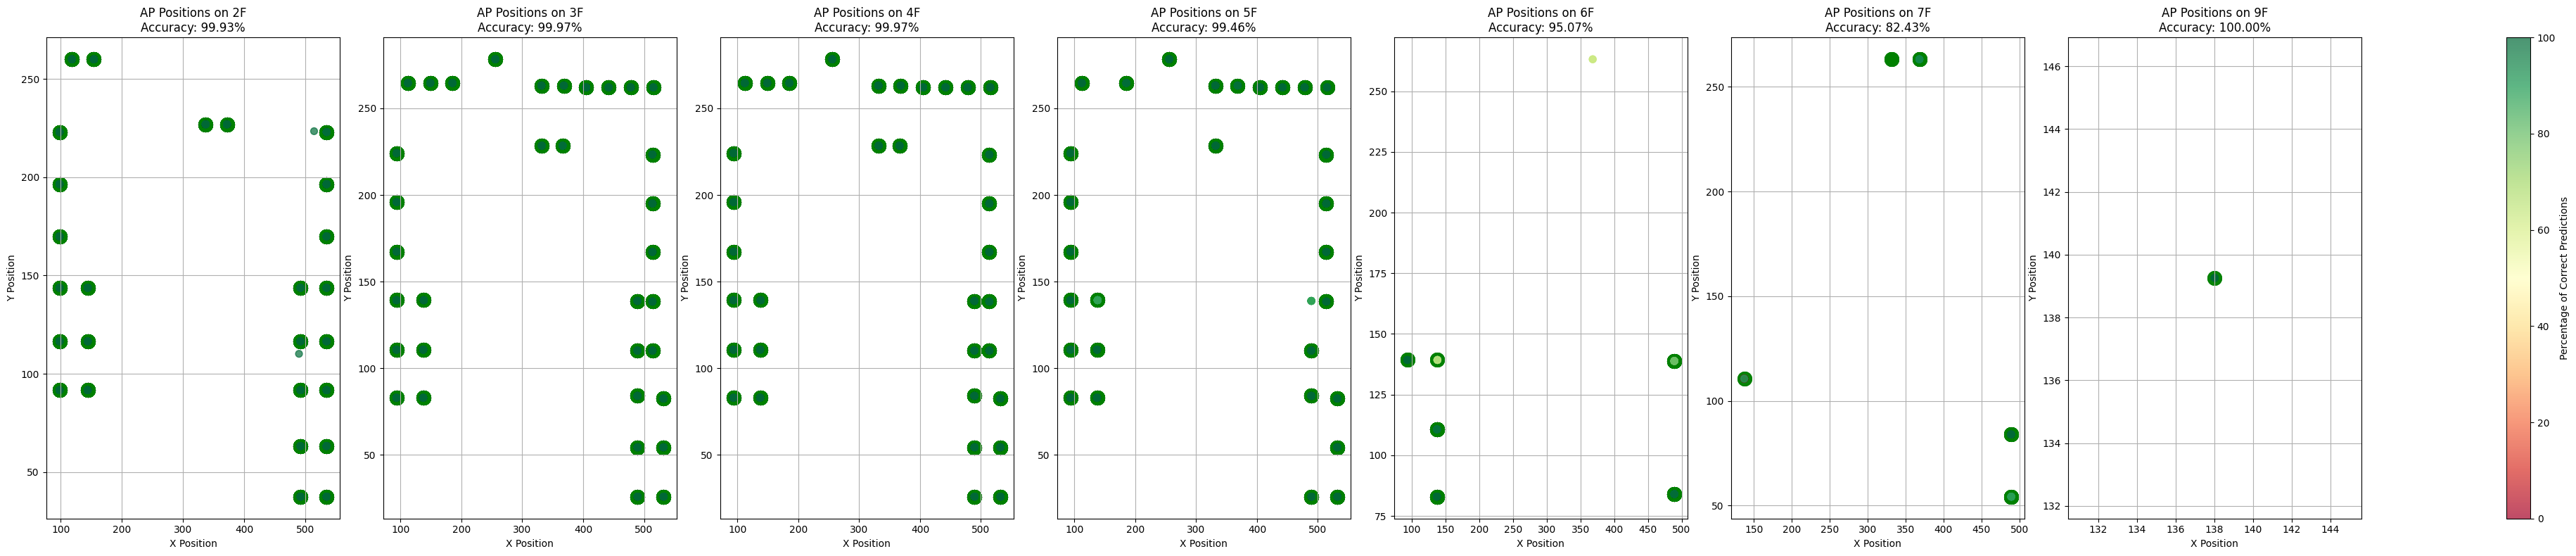

In [22]:
plot_ap_positions(data, decoded_y_test, decoded_y_pred)

## Regression Model

In [23]:
d_loc = data.iloc[:, 4:-1]
d_loc = d_loc.drop(columns=['ap_name'])

In [24]:
X = d_loc.iloc[:, :-3]
y = d_loc.iloc[:, -3:]

In [25]:
regression_data_scaled = RobustScaler().fit_transform(X)
dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(robust_scaled_data, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [27]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [28]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

In [29]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [30]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'x' if i==0 else 'y' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.3
estimator__max_depth: 5
estimator__n_estimators: 300

All hyperparameters of the best model:

Estimator for dimension 1 (x):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.3
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 300
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: None
 

In [31]:
# Make predictions
y_pred = best_model.predict(X_test)

In [32]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nOverall Mean Squared Error: {mse}")

# Calculate and print MSE for each coordinate
for i, coord in enumerate(['x', 'y', 'z']):
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"MSE for {coord}: {mse}")


Overall Mean Squared Error: 102.84645869221747
MSE for x: 282.3698563415208
MSE for y: 22.845010840643134
MSE for z: 3.3245088944885013


In [33]:
# Feature importance
feature_importance = np.mean([estimator.feature_importances_ for estimator in best_model.estimators_], axis=0)
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance_df.head(10))


Top 10 most important features:
            feature  importance
31  rssi_D1_3F_AP04    0.062891
5   rssi_D1_2F_AP06    0.060450
34  rssi_D1_3F_AP07    0.054906
30  rssi_D1_3F_AP03    0.050583
54  rssi_D1_3F_AP27    0.050582
20  rssi_D1_2F_AP21    0.043190
27  rssi_D1_2F_AP28    0.042080
29  rssi_D1_3F_AP02    0.037590
32  rssi_D1_3F_AP05    0.035913
24  rssi_D1_2F_AP25    0.034709


In [34]:
# Save the model
for i, estimator in enumerate(best_model.estimators_):
    estimator.save_model(f'xgboost_ap_position_model_all_{i}.json')

In [37]:
def plot_3d_ap_positions(y_true, y_pred):
    # Calculate MSE for each point
    mse = np.mean((y_true - y_pred)**2, axis=1)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot ground truth positions in blue
    ax.scatter(y_true[:, 0], y_true[:, 1], y_true[:, 2], 
               c='blue', marker='o', s=100, alpha=1, label='Ground Truth')
    
    norm = Normalize(vmin=0, vmax=10)
    # Plot predicted positions with color based on MSE
    scatter = ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
                         c=mse, norm=norm, cmap='Oranges_r', s=30, alpha=0.7, label='Predicted')
    
    # Add colorbar
    cbar = fig.colorbar(scatter)
    cbar.set_label('Mean Squared Error')
    
    # Calculate overall MSE
    overall_mse = mean_squared_error(y_true, y_pred)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.legend()
    plt.title(f'3D AP Positions - Overall MSE: {overall_mse:.4f}')
    
    plt.tight_layout()
    plt.show()


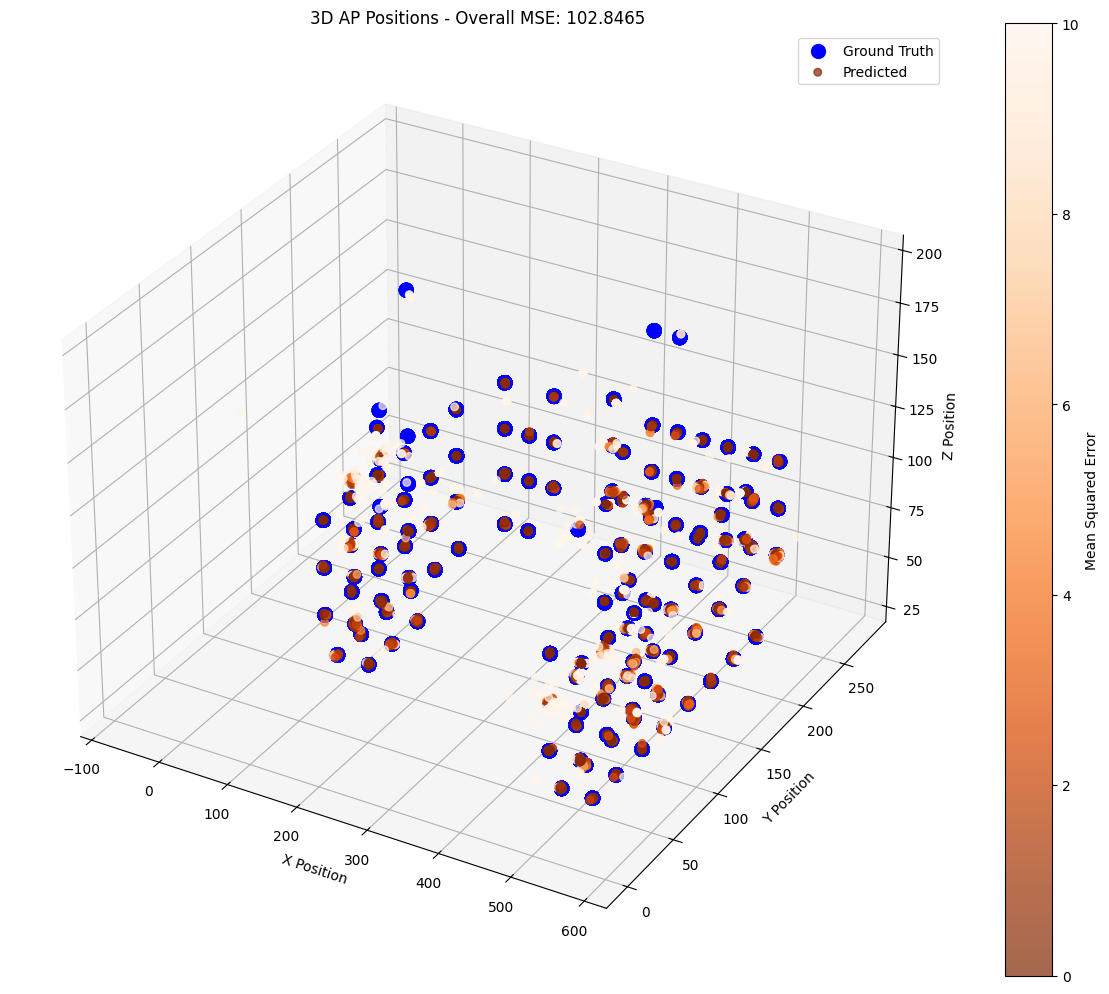

In [39]:
plot_3d_ap_positions(y_test.to_numpy(), y_pred)